# Трансферное обучение

## Импорт библиотек

In [20]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset, DatasetDict
import matplotlib.pyplot as plt

from typing import Any, Dict, Optional, Tuple

from collections import Counter
import pandas as pd

## Определение класса DatasetManager

In [21]:
class DatasetManager:
    """
    Менеджер для загрузки, анализа и подготовки датасета для задачи детекции спама.
    """

    def __init__(
        self,
        dataset_name: str = "sms_spam",
        text_column: str = "sms",
        validation_split: float = 0.2,
        test_split: float = 0.1,
        seed: int = 42,
    ) -> None:
        """
        Менеджер для загрузки, анализа и подготовки датасета для задачи детекции спама.

        Параметры:
            dataset_name (str): Название датасета.
            text_column (str): Колонка с текстом.
            validation_split (float): Доля валидационной выборки.
            test_split (float): Доля тестовой выборки.
            seed (int): Сид для воспроизводимости.
        """
        self.text_column: str = text_column
        raw = load_dataset(dataset_name)

        if "test" not in raw:
            train_temp = raw["train"].train_test_split(
                test_size=test_split + validation_split, seed=seed
            )

            temp = train_temp["test"].train_test_split(
                test_size=test_split / (test_split + validation_split), seed=seed
            )

            self.dataset = DatasetDict(
                {
                    "train": train_temp["train"],
                    "validation": temp["train"],
                    "test": temp["test"],
                }
            )
        else:
            self.dataset = raw

        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    def summary(self) -> None:
        """
        Выводит статистику по датасету:
        1. Распределение примеров между train/validation/test
        2. Распределение классов в обучающей выборке
        """
        sizes = {split: len(ds) for split, ds in self.dataset.items()}
        labels = list(self.dataset["train"]["label"])
        dist = Counter(labels)

        df1 = pd.DataFrame.from_dict(sizes, orient="index", columns=["Samples"])
        df2 = pd.DataFrame({"Label": list(dist.keys()), "Count": list(dist.values())})

        print("\033[92mDataset Splits:\033[0m")
        print(df1.to_markdown())
        print("\n\033[92mClass Distribution (train):\033[0m")
        print(df2.to_markdown(index=False))

    def show_samples(self, n: int = 5) -> None:
        """
        Отображает первые n записей с текстом и меткой.

        Параметры:
            n (int): число примеров.
        """
        ds = self.dataset["train"]
        print(f"\033[92mFirst {min(n, len(ds))} samples:\033[0m")
        for idx in range(min(n, len(ds))):
            example = ds[idx]
            label = example["label"]
            text = example[self.text_column]
            print(f"Sample {idx+1:2d}: [{label}] {text}")

    def preprocess(
        self,
        max_length: int = 128,
    ) -> DatasetDict:
        """
        Токенизация текстов и добавление поля 'labels'.

        Параметры:
            max_length (int): максимальная длина последовательности.

        Возвращает:
            DatasetDict: токенизированный датасет с 'input_ids', 'attention_mask', 'labels'.
        """

        def tokenize_fn(example: Dict[str, Any]) -> Dict[str, Any]:
            tokens = self.tokenizer(
                example[self.text_column],
                truncation=True,
                max_length=max_length,
            )
            tokens["labels"] = example["label"]
            return tokens

        tokenized = self.dataset.map(
            tokenize_fn,
            batched=True,
            remove_columns=self.dataset["train"].column_names,
        )
        return tokenized

## Определение класса SpamClassifier

In [22]:
class SpamClassifier:
    """
    Обёртка для DistilBERT, обучаемая на задаче классификации спама.
    """

    def __init__(
        self,
        num_labels: int,
        output_dir: str = "./spam_model",
        epochs: int = 5,
        batch_size: int = 8,
        learning_rate: float = 2e-5,
    ) -> None:
        """
        Инициализация модели и параметров тренировки.

        Параметры:
            num_labels (int): количество классов.
            output_dir (str): директория для результатов.
            epochs (int): число эпох.
            batch_size (int): размер батча.
            learning_rate (float): скорость обучения.
        """
        self.tokenizer: Optional[AutoTokenizer] = None
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=num_labels
        )
        self.args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            logging_strategy="epoch",
            logging_dir=f"{output_dir}/logs",
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
        )
        self.trainer: Optional[Trainer] = None

    def compute_metrics(
        self,
        eval_pred: Tuple[Any, Any],
    ) -> Dict[str, float]:
        """
        Вычисляет accuracy по предсказаниям.

        Параметры:
            eval_pred: кортеж (логиты, метки).
        Возвращает:
            Dict[str, float]: {'accuracy': value}.
        """
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        accuracy = (preds == labels).astype(float).mean().item()
        return {"accuracy": accuracy}

    def train(
        self,
        tokenized_dataset: DatasetDict,
        tokenizer: AutoTokenizer,
    ) -> Trainer:
        """
        Запускает тренировку и валидацию модели.

        Параметры:
            tokenized_dataset: токенизированные 'train' и 'validation'.
            tokenizer: токенизатор для паддинга.
        Возвращает:
            Trainer: объект Trainer.
        """
        self.tokenizer = tokenizer
        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        trainer = Trainer(
            model=self.model,
            args=self.args,
            train_dataset=tokenized_dataset["train"],
            eval_dataset=tokenized_dataset["validation"],
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics,
        )
        trainer.train()
        trainer.save_model(self.args.output_dir)
        self.trainer = trainer
        return trainer

    def test(self, tokenized_dataset: DatasetDict) -> Dict[str, float]:
        """
        Прогоняет модель на тестовом наборе и возвращает метрики.

        Параметры:
            tokenized_dataset (DatasetDict): Датасет с токенизированным сплитом 'test'.

        Возвращает:
            Dict[str, float]: Метрики оценки.
        """
        print("\n\033[92mTesting on test split...\033[0m")
        metrics = self.trainer.evaluate(eval_dataset=tokenized_dataset["test"])
        test_accuracy = metrics.get("eval_accuracy", 0.0)
        print(f"\033[92mTest Accuracy: {test_accuracy:.4f}\033[0m")
        return metrics

    def plot_loss(self) -> None:
        """
        Строит график train_loss, eval_loss и test_loss по эпохам.
        """
        train_epochs, train_losses = [], []
        eval_epochs, eval_losses = [], []
        for record in self.trainer.state.log_history:
            if "epoch" in record:
                if (
                    "loss" in record
                    and "eval_loss" not in record
                    and "test_loss" not in record
                ):
                    train_epochs.append(record["epoch"])
                    train_losses.append(record["loss"])
                if "eval_loss" in record:
                    eval_epochs.append(record["epoch"])
                    eval_losses.append(record["eval_loss"])
        plt.figure(figsize=(6, 4))
        plt.plot(train_epochs, train_losses, marker="o", label="Train Loss")
        plt.plot(eval_epochs, eval_losses, marker="o", label="Eval Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self) -> None:
        """
        Строит график train_accuracy, eval_accuracy и test_accuracy по эпохам.
        """
        eval_epochs, eval_accs = [], []
        for record in self.trainer.state.log_history:
            if "epoch" in record:
                if "eval_accuracy" in record:
                    eval_epochs.append(record["epoch"])
                    eval_accs.append(record["eval_accuracy"])
        plt.figure(figsize=(6, 4))
        plt.plot(eval_epochs, eval_accs, marker="o", label="Eval Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy over Epochs")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Инициализация датасета

In [23]:
manager = DatasetManager(
    dataset_name="sms_spam",
    text_column="sms",
    validation_split=0.2,
    test_split=0.1,
    seed=42,
)

## Параметры датасета

In [24]:
manager.summary()

Dataset Splits:
|            |   Samples |
|:-----------|----------:|
| train      |      3901 |
| validation |      1115 |
| test       |       558 |

Class Distribution (train):
|   Label |   Count |
|--------:|--------:|
|       0 |    3383 |
|       1 |     518 |


## Пример N записей

In [25]:
manager.show_samples(n=10)

First 10 samples:
Sample  1: [0] if you text on your way to cup stop that should work. And that should be BUS

Sample  2: [0] They said ü dun haf passport or smth like dat.. Or ü juz send to my email account..  

Sample  3: [0] Yay can't wait to party together!

Sample  4: [0] I take it we didn't have the phone callon Friday. Can we assume we won't have it this year now?

Sample  5: [0] You're right I have now that I think about it

Sample  6: [0] Even if he my friend he is a priest call him now

Sample  7: [0] Purity of friendship between two is not about smiling after reading the forwarded message..Its about smiling just by seeing the name. Gud evng

Sample  8: [0] get ready to moan and scream :)

Sample  9: [1] Rock yr chik. Get 100's of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel

Sample 10: [0] What's happening with you. Have you gotten a job and have you begun registration for permanent residency



## Предобработка датасета и инициализация модели

In [26]:
tokenized = manager.preprocess(max_length=128)

classifier = SpamClassifier(num_labels=2)

dummy_input_ids = torch.zeros((1, 128), dtype=torch.long)
dummy_attention = torch.ones((1, 128), dtype=torch.long)

Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\python_projects\.venv\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Обучение модели

In [27]:
trainer = classifier.train(
    tokenized_dataset=tokenized,
    tokenizer=manager.tokenizer,
)

C:\Users\kof3st\AppData\Local\Temp\ipykernel_1448\1564869070.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.076800,0.054485,0.991031
2,0.017400,0.060541,0.989238
3,0.001100,0.082912,0.988341
4,0.000100,0.078764,0.991928
5,0.000100,0.079567,0.991928


## График ошибки модели

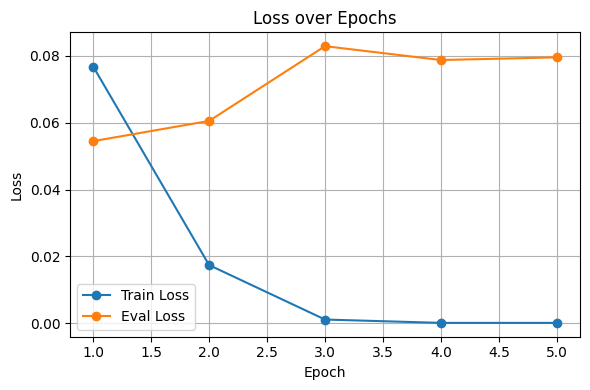

In [28]:
classifier.plot_loss()

## График точности модели

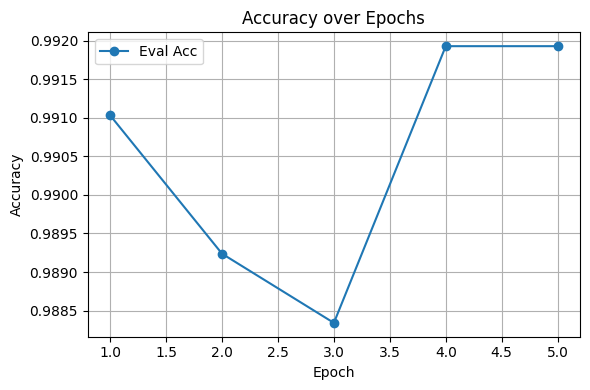

In [29]:
classifier.plot_accuracy()

## Проверка модели на тестовой выборке

In [31]:
classifier.test(tokenized)
print(
    "\033[92mTraining complete. Model and metrics saved to:\033[0m",
    classifier.args.output_dir,
)


Testing on test split...
Test Accuracy: 0.9946
Training complete. Model and metrics saved to: ./spam_model
